In [1]:
# 1. Download the datasets - Boston House pricing, Titanic survivors
# Do we do imputation? - No we skip for this excercise

# https://seaborn.pydata.org/tutorial/axis_grids.html

# 1. We are doing classification trees
#    Use Gini, Entropy gain, Information gain
#    Pruning


In [2]:
from sklearnex import patch_sklearn
patch_sklearn()

import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from matplotlib import pyplot as plt

from utils import get_data, get_df_details, plot_distrb, make_confusion_matrix

sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [ ]:
X, y, _, _ = get_data('cdc_diabetes_health_indicators')

In [9]:
# This is an imbalance dataset - use F1 metric for evaluation
# If both False Negatives and False Positives are equally important then we use F1-Score
y.value_counts(normalize=True)
# sns.countplot(y)

Diabetes_binary
0                  0.860667
1                  0.139333
Name: proportion, dtype: float64

In [10]:
# Split data into train and test sets.
# We use Stratifield sampling to ensure that the distribution of the data is maintained across the sample.
# Use stratified kfold cross validation to ensure that the model is not overfitting the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



# Train DecisionTreeClassifier

In [22]:
#  Need to do one hot encoding for the categorical data
# https://www.freecodecamp.org/news/machine-learning-pipeline/

# We dont do imputatuon - drop the missing data to keep it simple
# Which columns to onehot encode - Income, Education, Age, GenHealth

RANDOM_STATE = 42
N_FOLDS = 10
N_JOBS = -1
SCORING = 'f1'

num_cols = ['BMI', 'MentHlth', 'PhysHlth']
cat_cols = bin_cols.tolist() + ['Income', 'Education', 'Age', 'GenHlth']

num_pipeline = Pipeline(steps=[
    ('scale', MinMaxScaler())
])
cat_pipeline = Pipeline(steps=[
    ('one-hot', OneHotEncoder(handle_unknown='ignore', drop='if_binary', sparse=False))
])

col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_cols),
    ('cat_pipeline', cat_pipeline, cat_cols)
    ],
    remainder='drop',
    n_jobs=N_JOBS)

from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=RANDOM_STATE)
clf_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', clf)
])



In [23]:
clf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('scale',
                                                                   MinMaxScaler())]),
                                                  ['BMI', 'MentHlth',
                                                   'PhysHlth']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('one-hot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['HighBP', 'HighChol',
                                                   'CholCheck', 'Smoker',
                                                   'Stroke',
                                                   'HeartDiseaseorAttack',
                                                   'PhysActivity', 'Fruits',
                                                   'Veggies',
                                                   'HvyAlcoholConsump',
                                                   'AnyHealthcare',
                                                   'NoDocbcCost', 'DiffWalk',
                                                   'Sex', 'Income', 'Education',
                                                   'Age', 'GenHlth'])])),
                ('model', DecisionTreeClassifier(random_state=42))])

In [24]:
# Since imbalanced dataset, use F1 score
from sklearn.metrics import f1_score

score = clf_pipeline.score(X_test, y_test)
print(f"Model score: {score}") # model accuracy

Model score: 0.7978752759381899


## Tune the DecisionTreeClassifier

In [27]:
# tuning the variables
from sklearn.model_selection import GridSearchCV

#    Use Gini, Entropy gain, Information gain
#    Pruning

grid_params = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [3, 7, 11],
    'model__min_samples_split': [2, 6, 10, 100],
    'model__min_samples_leaf': [1, 5, 10, 100]
}

gs = GridSearchCV(clf_pipeline, grid_params, cv=N_FOLDS, scoring=SCORING, n_jobs=N_JOBS, verbose=4,
                  return_train_score=True)
gs.fit(X_train, y_train)

print("Best Score of train set: "+str(gs.best_score_))
print("Best parameter set: "+str(gs.best_params_))
print("Test Score: "+str(gs.score(X_test,y_test)))

Fitting 10 folds for each of 96 candidates, totalling 960 fits
Best Score of train set: 0.24537325985915523
Best parameter set: {'model__criterion': 'gini', 'model__max_depth': 11, 'model__min_samples_leaf': 10, 'model__min_samples_split': 2}
Test Score: 0.21049099653282627


In [ ]:
gs.cv_results_.keys()

gs.cv_results_['mean_test_score']


In [28]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

# gs.best_estimator_ is the best model found by GridSearchCV
y_test_predictions = gs.predict(X_test)
# Generate confusion matrix for the predictions from the best model
conf_matrix = confusion_matrix(y_test, y_test_predictions)
conf_matrix

scores = {'accuracy_score':accuracy_score(y_test, y_test_predictions),
          'precision_score':precision_score(y_test, y_test_predictions),
          'recall_score':recall_score(y_test, y_test_predictions),
          'f1_score':f1_score(y_test, y_test_predictions)
}

print(scores)
# target_names=target_names
print(classification_report(y_test, y_test_predictions))


{'accuracy_score': 0.860868022705771, 'precision_score': 0.5026709401709402, 'recall_score': 0.1331164238223228, 'f1_score': 0.21049099653282627}
              precision    recall  f1-score   support

           0       0.87      0.98      0.92     43667
           1       0.50      0.13      0.21      7069

    accuracy                           0.86     50736
   macro avg       0.69      0.56      0.57     50736
weighted avg       0.82      0.86      0.82     50736



<Axes: >

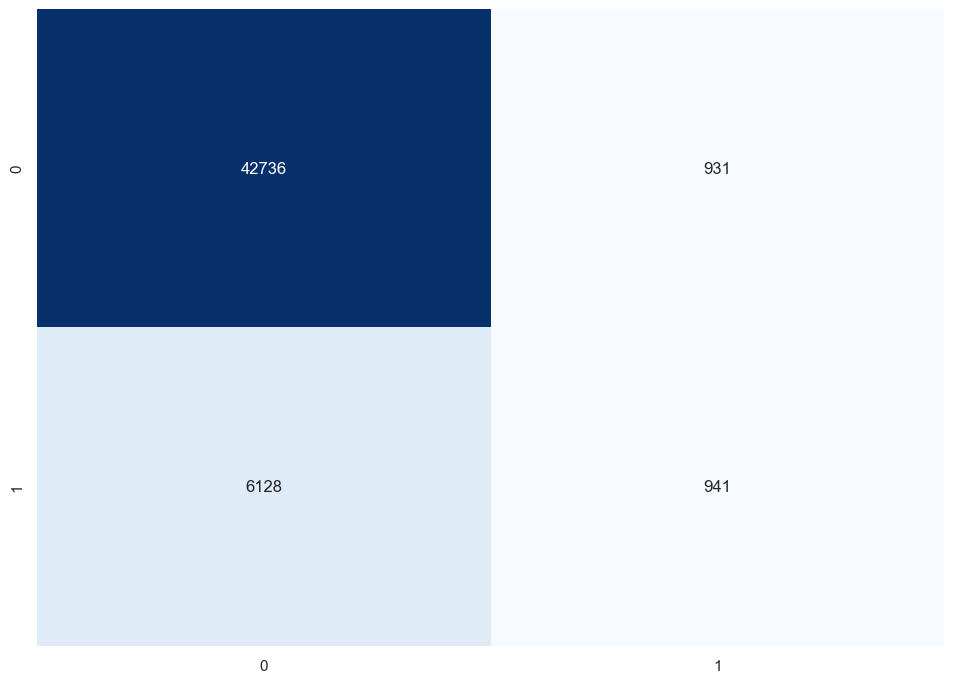

In [33]:
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

In [32]:
from utils import make_confusion_matrix
make_confusion_matrix(conf_matrix, group_names=['True Neg','False Pos','False Neg','True Pos'], categories=['No', 'Yes'], cmap='Blues')

ImportError: cannot import name 'make_confusion_matrix' from 'utils' (c:\Users\pavan\OneDrive\Documents\GaTech\CS7641_Lectures\PS_1\utils.py)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(gs, X_test, y_test)
plt.show()

In [ ]:
# https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv

# plot precison recall curve


In [ ]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import LearningCurveDisplay, StratifiedKFold

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": StratifiedKFold(n_splits=N_FOLDS, test_size=0.2, random_state=RANDOM_STATE),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "f1",
}

for ax_idx, estimator in enumerate([clf_pipeline]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

In [ ]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html